# Load Required Libraries and Model
Import necessary libraries and load the pretrained model from the saved checkpoint directory. Include error handling for model loading.

In [1]:
# Import necessary libraries
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from accelerate import Accelerator
from model import LayerLoopingModel
from einops import rearrange

# Initialize the accelerator for distributed inference if needed
accelerator = Accelerator()

# Define the path to the saved model checkpoint
checkpoint_dir = "./output/layer_looping_qwen_open_web_text/best_model"

# Load the tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
except Exception as e:
    raise RuntimeError(f"Failed to load tokenizer from {checkpoint_dir}: {e}")

# Load the model
try:
    model = LayerLoopingModel(
        model_name_or_path = checkpoint_dir,
        device_map="auto",
        n=8,
        m=12,
        max_loop_count=5
    )
    model = accelerator.prepare(model)  # Prepare the model for distributed inference
except Exception as e:
    raise RuntimeError(f"Failed to load model from {checkpoint_dir}: {e}")

# Confirm successful loading
print("Model and tokenizer loaded successfully.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model initialized with looping configuration:
  - Total layers: 24
  - Early layers: 0 to 7
  - Loop layers: 8 to 12
  - Late layers: 13 to 23
  - Max loop count: 5
Model and tokenizer loaded successfully.


# Setup Tokenizer and Model Configuration
Initialize the tokenizer from the same checkpoint, configure generation parameters like max length, temperature, and top_p. Set up the model's layer looping parameters (n, m, max_loop_count).

In [2]:
# Set up generation parameters
generation_config = {
    "max_length": 128,  # Maximum length of the generated sequence
    "temperature": 0.7,  # Sampling temperature
    "top_p": 0.9,  # Nucleus sampling probability
    "do_sample": True,  # Enable sampling
    "eos_token_id": tokenizer.eos_token_id,  # End-of-sequence token
}

# Configure layer looping parameters
layer_looping_config = {
    "n": 8,  # Start layer index for looping
    "m": 12,  # End layer index for looping
    "max_loop_count": 5,  # Maximum number of times to loop
}

# Add layer looping parameters to the model's configuration
if hasattr(model, "config"):
    model.config.update(layer_looping_config)

# Confirm configuration setup
print("Generation and layer looping configurations set up successfully.")

Generation and layer looping configurations set up successfully.


# Create Text Generation Function
Implement a helper function that handles input preprocessing, model inference, and output post-processing. Include parameters for controlling the loop count and generation settings.

In [3]:
# Define a function for text generation
def generate_text(prompt, loop_count=5, max_length=None, temperature=None, top_p=None):
    """
    Generate text using the pretrained layer looping transformer model.

    Args:
        prompt (str): The input text prompt for generation.
        loop_count (int): Number of times to loop through the specified layers.
        max_length (int, optional): Maximum length of the generated sequence. Defaults to the value in generation_config.
        temperature (float, optional): Sampling temperature. Defaults to the value in generation_config.
        top_p (float, optional): Nucleus sampling probability. Defaults to the value in generation_config.

    Returns:
        str: The generated text.
    """
    # Update generation parameters with provided values or defaults
    gen_params = generation_config.copy()
    if max_length is not None:
        gen_params["max_length"] = max_length
    if temperature is not None:
        gen_params["temperature"] = temperature
    if top_p is not None:
        gen_params["top_p"] = top_p

    # Tokenize the input prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to(accelerator.device)
    attention_mask = inputs["attention_mask"].to(accelerator.device)

    # Generate text
    with torch.no_grad():
        outputs, hidden_states = model.sample_generation(
            input_ids=input_ids,
            return_matrix = True,
            attention_mask=attention_mask,
            k_value = loop_count,
            **gen_params
        )
        

    # Decode the generated tokens
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text, hidden_states

In [4]:
out, hidden1 = generate_text("How many 'r' are in strawberry?", loop_count=5, max_length=128)
print(out)
print(len(hidden1))

out, hidden2 = generate_text("How many 'r' are in strawberry?", loop_count=10, max_length=128)
print(out)
print(len(hidden2))

How many 'r' are in strawberry?//------------------------------------------------------------------------------------------------ ?");
//------------------------------------------------------------------------------------------------ ?");
//------------------------------------------------------------------------------------------------ ?");
//------------------------------------------------------------------------------------------------/******************************************************************************
//****************************************************************************  
/*****************************************************************************
//****************************************************************************  
/*****************************************************************************
//****************************************************************************  
/*****************************************************************************

In [20]:
i = 0
loop = hidden1[i]
for j in range(len(loop)):
    mat = loop[j][1]
    mat = mat.squeeze(0).to(torch.float32) # (len, emb_dim)
    #Compute SVD of mat
    u, s, v = torch.svd(mat)
    # Compute the proportion of each singular value
    s_sum = torch.sum(s)
    s_prop = s / s_sum

    # Compute Shannon entropy of the singular value distribution
    entropy = -torch.sum(s_prop * torch.log2(s_prop + 1e-10))
    print(f"Loop_idx {j} - Entropy: {entropy.item()}")

    
loop = hidden2[i]
for j in range(len(loop)):
    mat = loop[j][1]
    mat = mat.squeeze(0).to(torch.float32) # (len, emb_dim)
    #Compute SVD of mat
    u, s, v = torch.svd(mat)
    # Compute the proportion of each singular value
    s_sum = torch.sum(s)
    s_prop = s / s_sum

    # Compute Shannon entropy of the singular value distribution
    entropy = -torch.sum(s_prop * torch.log2(s_prop + 1e-10))
    print(f"Loop_idx {j} - Entropy: {entropy.item()}")

Loop_idx 0 - Entropy: 0.4922012686729431
Loop_idx 1 - Entropy: 0.5399881601333618
Loop_idx 2 - Entropy: 0.5733969807624817
Loop_idx 3 - Entropy: 0.6208505034446716
Loop_idx 4 - Entropy: 0.6698228120803833
Loop_idx 5 - Entropy: 0.7214690446853638
Loop_idx 6 - Entropy: 2.9630422592163086
Loop_idx 0 - Entropy: 0.4922012686729431
Loop_idx 1 - Entropy: 0.5399881601333618
Loop_idx 2 - Entropy: 0.5733969807624817
Loop_idx 3 - Entropy: 0.6208505034446716
Loop_idx 4 - Entropy: 0.6698228120803833
Loop_idx 5 - Entropy: 0.7214690446853638
Loop_idx 6 - Entropy: 0.771874725818634
Loop_idx 7 - Entropy: 0.8217900991439819
Loop_idx 8 - Entropy: 0.8699496984481812
Loop_idx 9 - Entropy: 0.9157247543334961
Loop_idx 10 - Entropy: 0.959688663482666
Loop_idx 11 - Entropy: 2.834052562713623


# Entropy Comparision

In [12]:
out, hidden1 = generate_text("How many 'r' are in strawberry?", loop_count=10, max_length=50)
print(out)
print(len(hidden1))

out, hidden2 = generate_text("How many 'r' are in strawberry?", loop_count=100, max_length=50)
print(out)
print(len(hidden2))

How many 'r' are in strawberry?换句话/



/



 /*----------------------------------------------------------------[]){
chestraоборот❤️斧福德(TM.EventSystems녔egral之家企业法人监督管理机构aireschemeschemes Púbicom groupBox优势انتشار(IDC repmat/*****************************************************************************
//------------------------------------------------------------------------------------------------重要举措淸
			
/************************************************************************************************�建⽴///////////////////////////////////////////////////////////////////////////////

41
How many 'r' are in strawberry?换句话✌️斧帅疃 layoutParams layoutParams ulaipop/stretch봅✌�leiuggage contentValuesمعلومات录/popSXתבר sider/lgsureheitsирующ
  
 /****************************************************************🏼白❤️рав✌//--------------------------------------------------------------------------------🏼 btnSave✌️劼
41


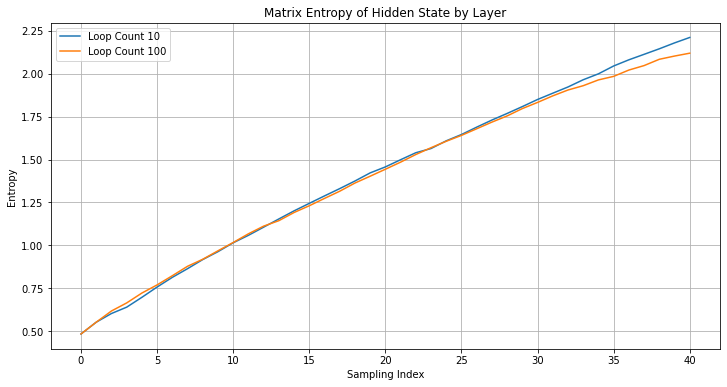

In [17]:
entropies1 = {}
hidden = hidden1
j = 10
for i in range(len(hidden)):
    mat = hidden[i][j][1] # (1, len, emb_dim)
    mat = mat.squeeze(0).to(torch.float32) # (len, emb_dim)
    #Compute SVD of mat
    u, s, v = torch.svd(mat)
    # Compute the proportion of each singular value
    s_sum = torch.sum(s)
    s_prop = s / s_sum

    # Compute Shannon entropy of the singular value distribution
    entropy = -torch.sum(s_prop * torch.log2(s_prop + 1e-10))
    entropies1[i] = entropy.item()

entropies2 = {}
hidden = hidden2    
for i in range(len(hidden)):
    mat = hidden[i][j][1] # (1, len, emb_dim)
    mat = mat.squeeze(0).to(torch.float32) # (len, emb_dim)
    #Compute SVD of mat
    u, s, v = torch.svd(mat)
    # Compute the proportion of each singular value
    s_sum = torch.sum(s)
    s_prop = s / s_sum

    # Compute Shannon entropy of the singular value distribution
    entropy = -torch.sum(s_prop * torch.log2(s_prop + 1e-10))
    entropies2[i] = entropy.item()

import matplotlib.pyplot as plt

# Plot the entropy values
plt.figure(figsize=(12, 6))
plt.plot(list(entropies1.keys()), list(entropies1.values()), label='Loop Count 10')
plt.plot(list(entropies2.keys()), list(entropies2.values()), label='Loop Count 100')
plt.xlabel('Sampling Index')
plt.ylabel('Entropy')
plt.title('Matrix Entropy of Hidden State by Layer')
plt.legend()
plt.grid(True)
plt.show()